In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install segmentation_models_pytorch

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 163kB 8.2MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=f18372f1194ceb6faa701a3d4be98bef137b100ec30d50d76d7023d7db2906ab
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=bd59224b4f144644bf0cf43cca7cfa50182ca472079ae30fed5c64586e3f40d0
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-fvdtu1hu
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-fvdtu1hu
     |████████████████████████████████| 952kB 5.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=72232 sha256=6c792729fd0ccd944b6f337135dd9da5f0c57d7e4ceb531855c37c3825803a7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-17qyxirx/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import segmentation_models_pytorch as smp
import albumentations as albu

In [ ]:
x_train_dir = '/content/drive/MyDrive/Hubmap256x256/train'
y_train_dir = '/content/drive/MyDrive/Hubmap256x256/masks'

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
def to_tensor(x, **kwargs):
    return np.transpose(x, (2,0,1)).astype('float32')

class HuBMAPDataset(Dataset):    
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            image = to_tensor(image)

        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
def get_training_augmentation(p=1.0):
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
                albu.OpticalDistortion(p=0.3),
                albu.GridDistortion(p=.1),
                albu.IAAPiecewiseAffine(p=0.3),
                ], p=0.9),
        albu.OneOf([
                albu.HueSaturationValue(10,15,10),
                albu.CLAHE(clip_limit=2),
                albu.RandomBrightnessContrast(),
            ], p=0.9,),
    ]
    return albu.Compose(train_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        # albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(256, 256, 3)
(256, 256)


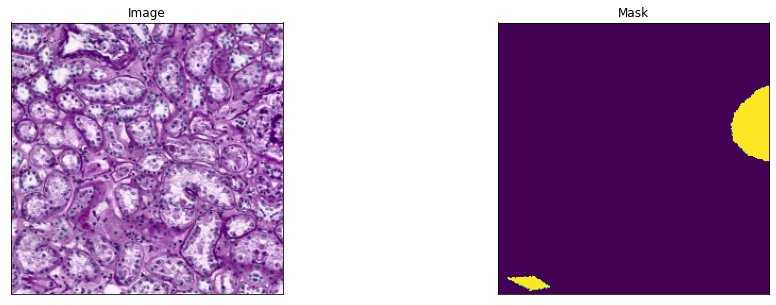

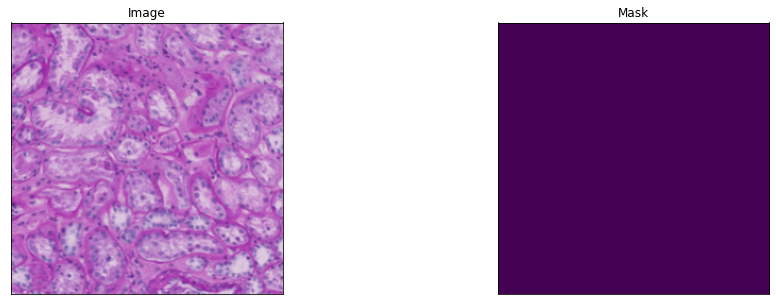

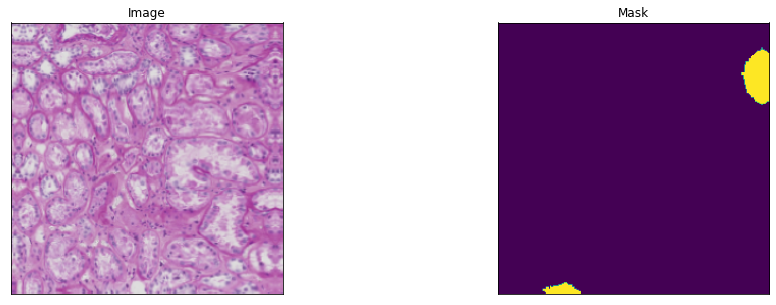

In [ ]:
dataset = HuBMAPDataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())

img, mask = dataset[4] # get some sample
print(img.shape)
print(mask.shape)

for i in range(3):
    image, mask = dataset[1]
    visualize(image=image, mask=mask)

In [ ]:
encoder = 'mobilenet_v2'
encoder_weights = 'imagenet'
activation = 'sigmoid'

In [ ]:
model = smp.FPN(encoder_name = encoder,
                encoder_weights = encoder_weights,
                classes = 1,
                activation = activation,
                )

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
train_dataset = HuBMAPDataset(x_train_dir, 
                        y_train_dir,
                        augmentation = get_training_augmentation(),
                        preprocessing = get_preprocessing(preprocessing_fn)
                        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

In [ ]:
for i_batch, (image, mask) in enumerate(train_loader):
  if i_batch > 3:
    break
  print(i_batch, image.size(),
          mask.size())

0 torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])
1 torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])
2 torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])
3 torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


In [ ]:
max_score = 0

for i in range(0, 1):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    
    # do something (save model, change lr, etc.)
    # if max_score < valid_logs['iou_score']:
    #     max_score = valid_logs['iou_score']
    #     torch.save(model, './best_model.pth')
    #     print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|██████████| 115/115 [35:16<00:00, 18.41s/it, dice_loss - -1.125, iou_score - 16.6]

Epoch: 1
train:  21%|██        | 24/115 [08:24<31:51, 21.01s/it, dice_loss - -1.09, iou_score - -3.165]


KeyboardInterrupt: ignored